# Clasificacion de Tumores con Pytorch

<b>Objetivos:</b>
1. Clasifición de Tumores
2. Comparar una red fully connected con una Convolucional
3. Utilizar ResNet18 desde cero
4. Utilizar ResNet18 con Transfer Learning

<b>Paquetes a instalar:</b>
Pytorch, Torchvision, cudnn, cudatoolkit, matplotlib


In [2]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [4]:
import os
from PIL import Image

# Path to your dataset folders
dataset_path = "DatasetTumoresCerebrales"

def get_image_dimensions_and_count(folder_path):
    dimensions_count = {}  # Store unique image dimensions and their count
    image_count = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png')):  # Add more image formats if needed
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    dimensions = img.size
                    if dimensions in dimensions_count:
                        dimensions_count[dimensions] += 1
                    else:
                        dimensions_count[dimensions] = 1
                    image_count += 1

    return dimensions_count, image_count

# Training set path
training_path = os.path.join(dataset_path, "training")
training_dimensions, training_image_count = get_image_dimensions_and_count(training_path)

# Test set path
test_path = os.path.join(dataset_path, "test")
test_dimensions, test_image_count = get_image_dimensions_and_count(test_path)

# Display results
def display_results(dimensions_count, image_count, set_name):
    print(f"{set_name} Set:")
    print(f"Number of images: {image_count}")
    print("Dimensions and their count:")
    for dimensions, count in dimensions_count.items():
        print(f"Dimensions: {dimensions}, Count: {count}")

display_results(training_dimensions, training_image_count, "Training")
display_results(test_dimensions, test_image_count, "Test")


Training Set:
Number of images: 2757
Dimensions and their count:
Dimensions: (256, 256), Count: 2757
Test Set:
Number of images: 307
Dimensions and their count:
Dimensions: (256, 256), Count: 307


In [5]:
#preprocess
def resize_images_in_folder(folder_path, target_size=(256, 256)):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png')):  # Add more image formats if needed
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    resized_img = img.resize(target_size, Image.ANTIALIAS)
                    resized_img.save(file_path)

# Resize images in the training set
training_path = os.path.join(dataset_path, "training")
resize_images_in_folder(training_path)

# Resize images in the test set
test_path = os.path.join(dataset_path, "test")
resize_images_in_folder(test_path)


In [6]:
training_dimensions, training_image_count = get_image_dimensions_and_count(training_path)
test_dimensions, test_image_count = get_image_dimensions_and_count(test_path)

display_results(training_dimensions, training_image_count, "Training")
display_results(test_dimensions, test_image_count, "Test")

Training Set:
Number of images: 2757
Dimensions and their count:
Dimensions: (256, 256), Count: 2757
Test Set:
Number of images: 307
Dimensions and their count:
Dimensions: (256, 256), Count: 307


## Dataset de Tumores
- Imágenes de 256 x 256 píxeles
- 2757 imágenes de training
- 308 imágenes de test


In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 256
EPOCHS = 8
IMAGE_SIZE = 256

#MODELS_DIR = 'models/'


Shape of X [N, C, H, W]: torch.Size([32, 1, 256, 256])
Number of labels: 32


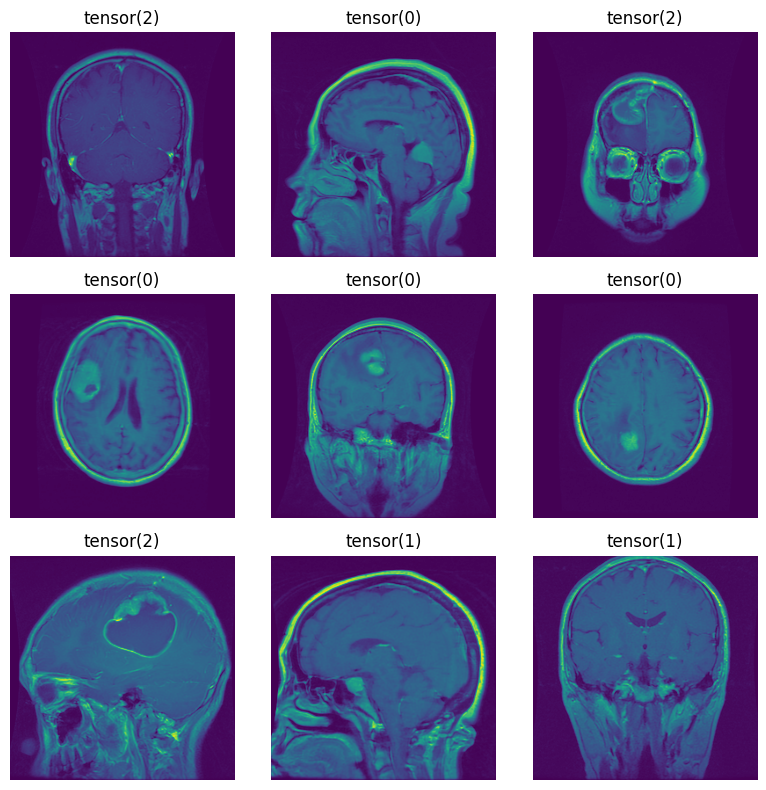

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []  # Add labels attribute

        classes = os.listdir(root_dir)
        for class_name in classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(('.png')):
                        self.images.append(os.path.join(class_dir, filename))
                        self.labels.append(class_name)  # Use folder name as label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]  # Retrieve label
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
            classes = ['Meningioma', 'Glioma', 'Pituitary tumor']
            label_to_index = {label: idx for idx, label in enumerate(set(classes))}
            numerical_label = label_to_index[label]
            label = torch.tensor(numerical_label)
        
        return image, label  # Return image and label


# Define the transforms you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()  # Convert to tensor
])

# Define the paths to your dataset folders
train_dataset = CustomDataset('DatasetTumoresCerebrales/training', transform=transform)
test_dataset = CustomDataset('DatasetTumoresCerebrales/test', transform=transform)

# creamos los Dataloader para cada conjunto
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import matplotlib.pyplot as plt
import torch

X, y = next(iter(train_dataloader))

classes = list(set(y)) 
#print(classes)
class_to_idx = {label: idx for idx, label in enumerate(set(classes))}
#numerical_labels = [label_to_index[label] for label in classes]
#y = torch.tensor(numerical_labels)
#y = torch.Tensor(y)

#print(type(X))
#print(type(y))

print(f"Shape of X [N, C, H, W]: {X.shape}")
print(f"Number of labels: {len(y)}")

# Convert tensor labels back to class names
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
y_labels = [idx_to_class[idx.item()] for idx in y]

# Display the first 9 images with their class labels
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i].permute(1, 2, 0))
    
    plt.title(y_labels[i])  # Use class names as titles
    
    plt.axis('off')
plt.tight_layout()
plt.show()




## Entrenamiento con fully connected network
- Creación de una red con 2 capas ocultas
- Estructura: entrada 784, oculta1 512, oculta2 512, salida 10

In [13]:
# Definimos el modelo
from torch import nn
from torchinfo  import summary

IMAGE_SIZE = 256
BATCH_SIZE = 256

# creamos la red feed-forward
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected,self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(IMAGE_SIZE*IMAGE_SIZE, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = FullyConnected().to(device)

summary(model,
        input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
FullyConnected (FullyConnected)          [256, 1, 256, 256]   [256, 10]            --                   True
├─Sequential (linear_relu_stack)         [256, 1, 256, 256]   [256, 10]            --                   True
│    └─Flatten (0)                       [256, 1, 256, 256]   [256, 65536]         --                   --
│    └─Linear (1)                        [256, 65536]         [256, 512]           33,554,944           True
│    └─ReLU (2)                          [256, 512]           [256, 512]           --                   --
│    └─Dropout (3)                       [256, 512]           [256, 512]           --                   --
│    └─Linear (4)                        [256, 512]           [256, 512]           262,656              True
│    └─ReLU (5)                          [256, 512]           [256, 512]           --                   --
│    └─Dropout (6)    

### Procedimientos de training y test

In [14]:
from torch import optim

# definimos la métrica y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# función de entrenamiento
def train(dataloader, model, loss_fn, optimizer, losses, accuracy):
    size = len(dataloader.dataset)

    model.train()
    correct = 0
    total_loss = 0  # Track total loss across all batches

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)  # Ensure labels are on the same device as model
        
        # Convert string labels to numerical labels for this batch
        label_to_index = {label: idx for idx, label in enumerate(set(y.tolist()))}
        numerical_labels = [label_to_index[label] for label in y.tolist()]
        numerical_labels = torch.tensor(numerical_labels).to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, numerical_labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == numerical_labels).type(torch.float).sum().item()
        total_loss += loss.item()

        if batch == 86:
            print(f"Processing the last batch...")

    # Calculate metrics after processing all batches
    train_acc = 100 * correct / size
    avg_loss = total_loss / size  # Calculate average loss over the entire dataset
    losses.append(avg_loss)
    accuracy.append(train_acc)

    # Print accuracy and loss at the end
    print(f"Accuracy: {train_acc:.2f}%, Avg loss: {avg_loss:.6f}")




# función de test
def test(dataloader, model, loss_fn, losses, accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc = 100*correct/size
    losses.append(test_loss)
    accuracy.append(test_acc)
    print(f"Test Error: \n Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Bucle principal para Fully Connected Network

In [40]:
# bucle de entranamiento
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")


Epoch 1
-------------------------------
Processing the last batch...
Accuracy: 57.89%, Avg loss: 0.044929
Test Error: 
 Accuracy: 68.1%, Avg loss: 0.696586 

Epoch 2
-------------------------------
Processing the last batch...
Accuracy: 64.60%, Avg loss: 0.024043
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.650956 

Epoch 3
-------------------------------
Processing the last batch...
Accuracy: 68.84%, Avg loss: 0.021721
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.532881 

Epoch 4
-------------------------------
Processing the last batch...
Accuracy: 70.69%, Avg loss: 0.021231
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.565602 

Epoch 5
-------------------------------
Processing the last batch...
Accuracy: 71.06%, Avg loss: 0.019792
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.580765 

Epoch 6
-------------------------------
Processing the last batch...
Accuracy: 69.13%, Avg loss: 0.020529
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.539565 

Epoch 7
-------------------------------
Processing t

In [41]:
torch.save(model.state_dict(), "model_ff.pth")
print("Model saved model_ff.pth")

Model saved model_ff.pth


In [1]:
train_loss = [0.044929, 0.024043, 0.021721, 0.021231, 0.019792, 0.020529, 0.019862, 0.020988]
train_acc = [57.89, 64.60, 68.84, 70.69, 71.06, 69.13, 71.02, 71.45]
test_acc = [68.1, 72.0, 73.6, 73.0, 73.6, 72.0, 73.9, 70.7]

In [42]:
model = FullyConnected()  # Replace YourModel with your model's class
model.load_state_dict(torch.load("model_ff.pth"))
model.eval()

FullyConnected(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)

# Gráficas de precisión y pérdida

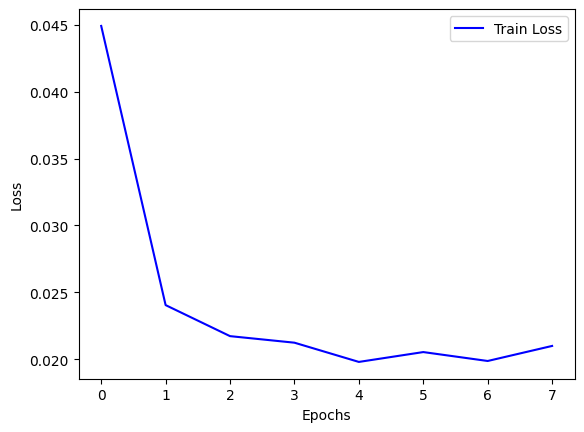

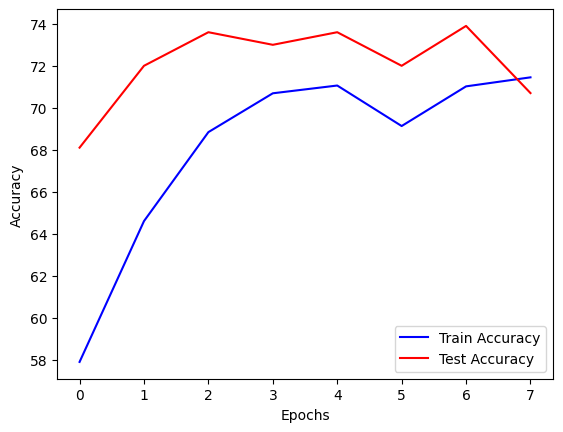

In [2]:
import matplotlib.pyplot as plt

def draw_graphics(train_loss, train_acc, test_acc):

    # Dibujamos las gráficas
    x = range(len(train_loss))
    plt.figure()
    plt.plot(x,train_loss, color='blue')
    plt.legend(['Train Loss'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('train_loss.svg')
    
    plt.figure()
    plt.plot(train_acc, color='blue')
    plt.plot(test_acc, color='red')
    plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('Accuracy.svg')
    
draw_graphics(train_loss, train_acc, test_acc)

### Visualización de imagenes mal clasificadas

Numero elementos por tipo de tumor: [ 93 143  71]
Total: 307


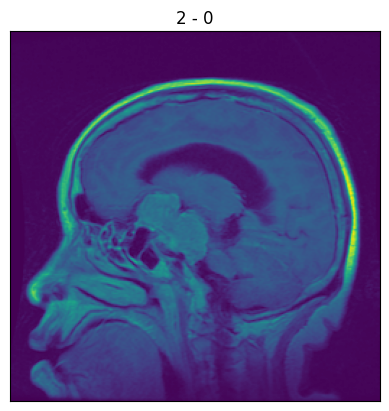

In [44]:
import numpy as np

# Función para buscar incorrectos y dibujarlos
def draw_incorrect(model, dataloader, num=3):
    for i in range(num):
        X, y = next(iter(dataloader))
        X, y = X.to(device), y.to(device)
        model.to(device)
        pred = model(X)
        incorrect = (pred.argmax(1) != y)
        for img,l,d in zip(X[incorrect],y[incorrect],pred[incorrect].argmax(1)):
            img, l = img.to('cpu'), l.to('cpu')
            plt.imshow(img.reshape((IMAGE_SIZE,IMAGE_SIZE)))
            plt.title(f"{l.item()} - {d.item()}")
            plt.xticks([])
            plt.yticks([])
        
# Contamos el número de elementos que hay de cada dígito
count = np.zeros(3, np.int32)
for _,y in test_dataloader:
    np.add.at(count, y, 1)

print("Numero elementos por tipo de tumor:", count)
print("Total:", count.sum())

draw_incorrect(model, test_dataloader)



## Entrenamiento con redes convolucionales simples

### ConvNet1
- 2 Bloques Convolucionales
- 1 Fully-connected

### ConvNet2
- 2 Bloques Convolucionales
- 1 Fully-connected
- BatchNormalization

### ConvNet3
- 3 Bloques Convolucionales
- 1 Fully-connected
- BatchNormalization


In [64]:
# Definimos las redes convolucionales
from torch import nn
from torchinfo import summary

def bloque_conv(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

def bloque_conv_norm(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, 1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = bloque_conv(1, 32)  # Adjust input channels to 1 for grayscale images
        self.conv2 = bloque_conv(32, 64)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 62 * 62, 128),  # Adjust the flattened size based on convolutions
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)  # Adjust output to predict 3 classes
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        logits = self.linear_out(x)
        return logits
    
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = bloque_conv_norm(1, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64 * 62 * 62, 3),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        logits = self.linear_out(x)
        return logits


class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = bloque_conv_norm(1, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.conv3 = bloque_conv_norm(64, 128)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128*30*30, 3),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        logits = self.linear_out(x)
        return logits


In [65]:
# creamos el modelo
model = ConvNet3() #ConvNet1 #ConvNet2
model.to(device)

summary(model,
        input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ConvNet3 (ConvNet3)                      [256, 1, 256, 256]   [256, 3]             --                   True
├─Sequential (conv1)                     [256, 1, 256, 256]   [256, 32, 127, 127]  --                   True
│    └─Conv2d (0)                        [256, 1, 256, 256]   [256, 32, 254, 254]  320                  True
│    └─BatchNorm2d (1)                   [256, 32, 254, 254]  [256, 32, 254, 254]  64                   True
│    └─ReLU (2)                          [256, 32, 254, 254]  [256, 32, 254, 254]  --                   --
│    └─MaxPool2d (3)                     [256, 32, 254, 254]  [256, 32, 127, 127]  --                   --
├─Sequential (conv2)                     [256, 32, 127, 127]  [256, 64, 62, 62]    --                   True
│    └─Conv2d (0)                        [256, 32, 127, 127]  [256, 64, 125, 125]  18,496               True
│    └─BatchNorm2d

In [66]:
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# bucle principal
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}/{EPOCHS}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")

torch.save(model.state_dict(), "model_cnn3.pth")
print("Model saved model_cnn3.pth")


Epoch 1/8
-------------------------------
Processing the last batch...
Accuracy: 70.40%, Avg loss: 1.204935
Test Error: 
 Accuracy: 67.8%, Avg loss: 22.699490 

Epoch 2/8
-------------------------------
Processing the last batch...
Accuracy: 80.41%, Avg loss: 0.275581
Test Error: 
 Accuracy: 81.4%, Avg loss: 3.010431 

Epoch 3/8
-------------------------------
Processing the last batch...
Accuracy: 86.43%, Avg loss: 0.036637
Test Error: 
 Accuracy: 85.0%, Avg loss: 1.046591 

Epoch 4/8
-------------------------------
Processing the last batch...
Accuracy: 91.33%, Avg loss: 0.019355
Test Error: 
 Accuracy: 78.5%, Avg loss: 1.441303 

Epoch 5/8
-------------------------------
Processing the last batch...
Accuracy: 89.84%, Avg loss: 0.013026
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.401851 

Epoch 6/8
-------------------------------
Processing the last batch...
Accuracy: 94.74%, Avg loss: 0.004944
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.342437 

Epoch 7/8
-----------------------------

0.0031049819780553504
96.08269858541894
90.22801302931596


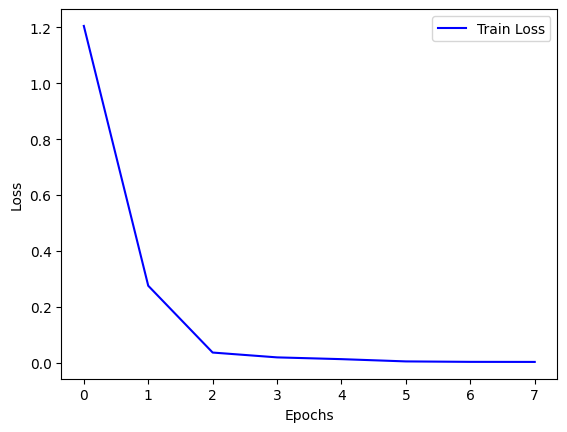

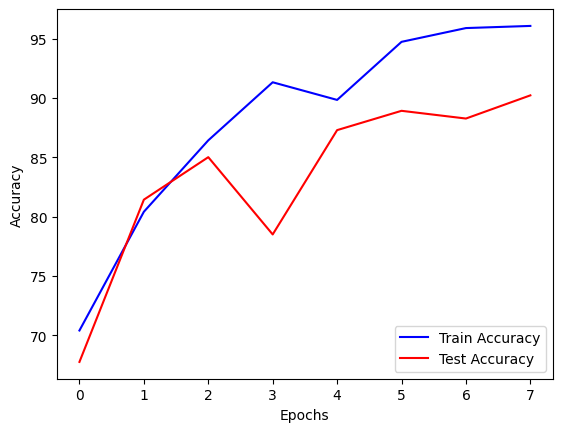

In [67]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)

## Entrenamiento con ResNet18 desde Cero


In [5]:
from torchvision.models import resnet18
from torchvision.transforms import Compose, Grayscale, ToTensor
from torchinfo  import summary

model = resnet18()
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) #to receive 1 channel images

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(in_features=num_features,
                    out_features=3,
                    bias=True)).to(device)

summary(model,
        input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [256, 1, 256, 256]   [256, 3]             --                   True
├─Conv2d (conv1)                         [256, 1, 256, 256]   [256, 64, 128, 128]  3,136                True
├─BatchNorm2d (bn1)                      [256, 64, 128, 128]  [256, 64, 128, 128]  128                  True
├─ReLU (relu)                            [256, 64, 128, 128]  [256, 64, 128, 128]  --                   --
├─MaxPool2d (maxpool)                    [256, 64, 128, 128]  [256, 64, 64, 64]    --                   --
├─Sequential (layer1)                    [256, 64, 64, 64]    [256, 64, 64, 64]    --                   True
│    └─BasicBlock (0)                    [256, 64, 64, 64]    [256, 64, 64, 64]    --                   True
│    │    └─Conv2d (conv1)               [256, 64, 64, 64]    [256, 64, 64, 64]    36,864               True
│    │    └─BatchN

In [8]:
# train model
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = EPOCHS
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)
print("Done!")

Epoch 1/8
-------------------------------
Processing the last batch...
Accuracy: 75.77%, Avg loss: 0.018167
Test Error: 
 Accuracy: 63.5%, Avg loss: 1.865169 

Epoch 2/8
-------------------------------
Processing the last batch...
Accuracy: 82.48%, Avg loss: 0.013203
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.606222 

Epoch 3/8
-------------------------------
Processing the last batch...
Accuracy: 85.93%, Avg loss: 0.011602
Test Error: 
 Accuracy: 64.8%, Avg loss: 1.796561 

Epoch 4/8
-------------------------------
Processing the last batch...
Accuracy: 87.27%, Avg loss: 0.009698
Test Error: 
 Accuracy: 41.7%, Avg loss: 3.588185 

Epoch 5/8
-------------------------------
Processing the last batch...
Accuracy: 90.53%, Avg loss: 0.007790
Test Error: 
 Accuracy: 62.2%, Avg loss: 1.446559 

Epoch 6/8
-------------------------------
Processing the last batch...
Accuracy: 92.27%, Avg loss: 0.006405
Test Error: 
 Accuracy: 49.8%, Avg loss: 3.896027 

Epoch 7/8
------------------------------

NameError: name 'MODELS_DIR' is not defined

In [9]:
torch.save(model.state_dict(), "model_resnet.pth")
print("Model saved to model_resnet.pth")

Model saved to model_resnet.pth


0.0054182135457788464
94.05150525933986
51.14006514657981


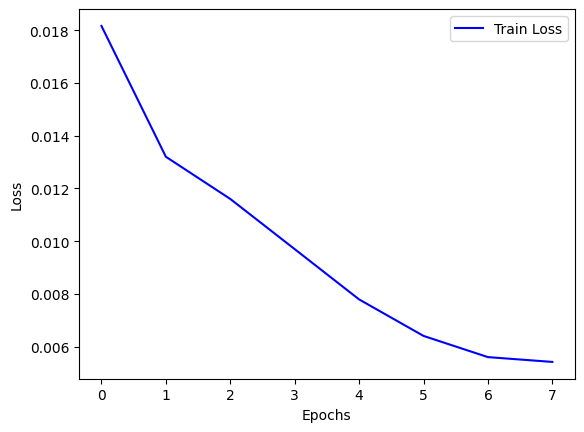

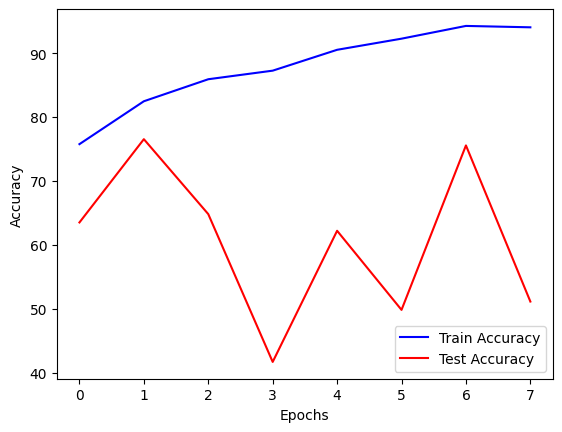

In [12]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)

## Entrenamiento con ResNet18 y Transfer Learning



In [16]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Grayscale
import numpy as np
from torchinfo  import summary

# Instanciamos el modelo ResNet18 con los pesos por defecto
weights=ResNet18_Weights.DEFAULT
auto_transforms = weights.transforms()

transform=Compose([
    Grayscale(num_output_channels=3),
    auto_transforms,
])

# Define the paths to your dataset folders
train_dataset = CustomDataset('DatasetTumoresCerebrales/training', transform=transform)
test_dataset = CustomDataset('DatasetTumoresCerebrales/test', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Estructura de los batches
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Creamos el modelo y congelamos parámetros de la red
model = resnet18(weights=weights).to(device)
for name, para in model.named_parameters():
    para.requires_grad = False

# Cambiamos la capa superior con una capa Lineal con 10 clases de salida
num_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=num_features,
                    out_features=3,
                    bias=True).to(device)

summary(model,
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Shape of X [N, C, H, W]: torch.Size([256, 3, 224, 224])
Shape of y: torch.Size([256]) torch.int64


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [256, 3, 256, 256]   [256, 3]             --                   Partial
├─Conv2d (conv1)                         [256, 3, 256, 256]   [256, 64, 128, 128]  (9,408)              False
├─BatchNorm2d (bn1)                      [256, 64, 128, 128]  [256, 64, 128, 128]  (128)                False
├─ReLU (relu)                            [256, 64, 128, 128]  [256, 64, 128, 128]  --                   --
├─MaxPool2d (maxpool)                    [256, 64, 128, 128]  [256, 64, 64, 64]    --                   --
├─Sequential (layer1)                    [256, 64, 64, 64]    [256, 64, 64, 64]    --                   False
│    └─BasicBlock (0)                    [256, 64, 64, 64]    [256, 64, 64, 64]    --                   False
│    │    └─Conv2d (conv1)               [256, 64, 64, 64]    [256, 64, 64, 64]    (36,864)             False
│    │    

In [23]:
# train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = EPOCHS
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)
print("Done!")

torch.save(model.state_dict(), "model_resnet_tl1.pth")
print("Model saved to model_resnet_tl1.pth")



Epoch 1/8
-------------------------------
Accuracy: 80.32%, Avg loss: 0.005848
Test Error: 
 Accuracy: 46.6%, Avg loss: 18.080645 

Epoch 2/8
-------------------------------
Accuracy: 86.60%, Avg loss: 0.002171
Test Error: 
 Accuracy: 46.6%, Avg loss: 24.213265 

Epoch 3/8
-------------------------------
Accuracy: 85.84%, Avg loss: 0.001860
Test Error: 
 Accuracy: 46.6%, Avg loss: 25.797920 

Epoch 4/8
-------------------------------
Accuracy: 89.24%, Avg loss: 0.001504
Test Error: 
 Accuracy: 46.6%, Avg loss: 26.082387 

Epoch 5/8
-------------------------------
Accuracy: 89.60%, Avg loss: 0.001378
Test Error: 
 Accuracy: 46.9%, Avg loss: 25.592707 

Epoch 6/8
-------------------------------
Accuracy: 89.32%, Avg loss: 0.001333
Test Error: 
 Accuracy: 46.9%, Avg loss: 24.513466 

Epoch 7/8
-------------------------------
Accuracy: 88.76%, Avg loss: 0.001308
Test Error: 
 Accuracy: 47.2%, Avg loss: 23.346306 

Epoch 8/8
-------------------------------
Accuracy: 88.64%, Avg loss: 0.0012

0.00129508858025074
88.64
47.23127035830619


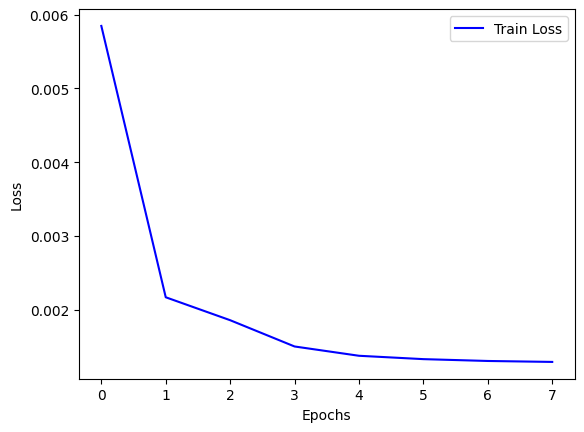

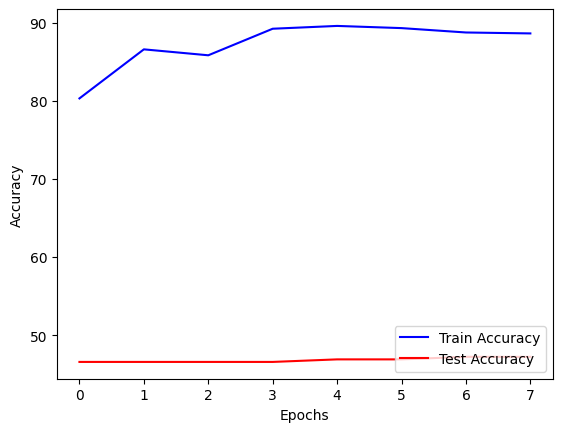

In [24]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)

In [18]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load pre-trained ResNet18 model with weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights).to(device)

# Freeze layers
for name, param in model.named_parameters():
    if "fc" not in name:  # Except for the final fully connected layer
        param.requires_grad = False

# Get the number of input features for the new fully connected layer
num_features = model.fc.in_features

# Redefine the final fully connected layers
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_features),
    nn.Dropout(0.5),  # Dropout layer
    nn.Linear(num_features, 256),  # Additional fully connected layer
    nn.ReLU(),  # Activation function
    nn.BatchNorm1d(256),  # Batch Normalization
    nn.Dropout(0.5),  # Dropout layer
    nn.Linear(256, 3),  # Output layer with 3 classes
).to(device)

# Applying L2 regularization to the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Summary of the updated model
summary(model,
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [256, 3, 256, 256]   [256, 3]             --                   Partial
├─Conv2d (conv1)                         [256, 3, 256, 256]   [256, 64, 128, 128]  (9,408)              False
├─BatchNorm2d (bn1)                      [256, 64, 128, 128]  [256, 64, 128, 128]  (128)                False
├─ReLU (relu)                            [256, 64, 128, 128]  [256, 64, 128, 128]  --                   --
├─MaxPool2d (maxpool)                    [256, 64, 128, 128]  [256, 64, 64, 64]    --                   --
├─Sequential (layer1)                    [256, 64, 64, 64]    [256, 64, 64, 64]    --                   False
│    └─BasicBlock (0)                    [256, 64, 64, 64]    [256, 64, 64, 64]    --                   False
│    │    └─Conv2d (conv1)               [256, 64, 64, 64]    [256, 64, 64, 64]    (36,864)             False
│    │    

In [19]:
# train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = EPOCHS
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)
print("Done!")

torch.save(model.state_dict(), "model_resnet_tl1_better.pth")
print("Model saved to model_resnet_tl1_better.pth")


Epoch 1/8
-------------------------------
Accuracy: 46.24%, Avg loss: 0.004608
Test Error: 
 Accuracy: 40.4%, Avg loss: 0.879228 

Epoch 2/8
-------------------------------
Accuracy: 68.16%, Avg loss: 0.003174
Test Error: 
 Accuracy: 37.8%, Avg loss: 1.152747 

Epoch 3/8
-------------------------------
Accuracy: 84.24%, Avg loss: 0.002049
Test Error: 
 Accuracy: 30.6%, Avg loss: 1.688786 

Epoch 4/8
-------------------------------
Accuracy: 88.64%, Avg loss: 0.001548
Test Error: 
 Accuracy: 30.3%, Avg loss: 1.617765 

Epoch 5/8
-------------------------------
Accuracy: 89.68%, Avg loss: 0.001354
Test Error: 
 Accuracy: 32.6%, Avg loss: 1.418745 

Epoch 6/8
-------------------------------
Accuracy: 89.68%, Avg loss: 0.001204
Test Error: 
 Accuracy: 31.6%, Avg loss: 1.532359 

Epoch 7/8
-------------------------------
Accuracy: 89.88%, Avg loss: 0.001209
Test Error: 
 Accuracy: 30.3%, Avg loss: 1.497574 

Epoch 8/8
-------------------------------
Accuracy: 90.24%, Avg loss: 0.001179
Test

0.0011794741332530976
90.24
30.293159609120522


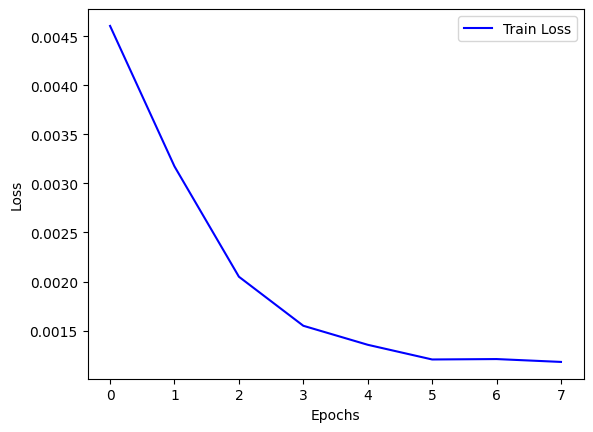

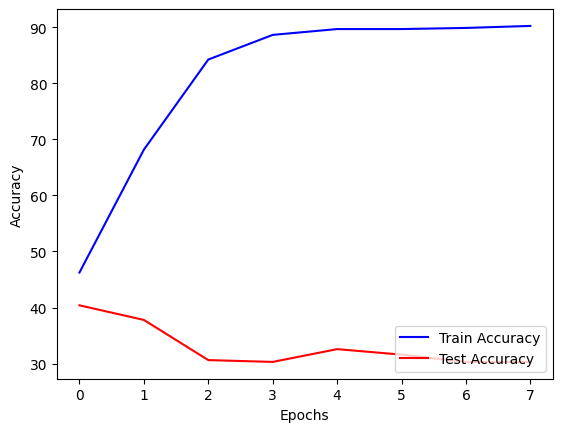

In [22]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)

# Reduce overfitting

In [28]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Grayscale
from torch.utils.data import DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define constants
BATCH_SIZE = 256
IMAGE_SIZE = 256

# Define dataset and dataloaders
# Assuming CustomDataset and transforms are defined elsewhere
train_dataset = CustomDataset('DatasetTumoresCerebrales/training', transform=transform)
test_dataset = CustomDataset('DatasetTumoresCerebrales/test', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Load pre-trained ResNet18 model with weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights).to(device)

# Freeze layers
for name, param in model.named_parameters():
    param.requires_grad = False

# Define the number of input features for the new fully connected layer
num_features = model(torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)).view(-1).shape[0]

# Create a new classifier module
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 3)  # Output layer with 3 classes
).to(device)

# Add the classifier to the model
model.add_module('classifier', classifier)

# Move the entire model to the device
model = model.to(device)

# Unfreeze a portion of the ResNet layers for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True  # Set the parameters to be trainable

# Define optimizer and loss function
optimizer = torch.optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.0001},  # Lower learning rate for fine-tuning
    {'params': model.classifier.parameters(), 'lr': 0.001}  # Higher learning rate for the classifier
])


# Summary of the updated model
summary(model,
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [256, 3, 256, 256]   [256, 1000]          257,539              Partial
├─Conv2d (conv1)                         [256, 3, 256, 256]   [256, 64, 128, 128]  (9,408)              False
├─BatchNorm2d (bn1)                      [256, 64, 128, 128]  [256, 64, 128, 128]  (128)                False
├─ReLU (relu)                            [256, 64, 128, 128]  [256, 64, 128, 128]  --                   --
├─MaxPool2d (maxpool)                    [256, 64, 128, 128]  [256, 64, 64, 64]    --                   --
├─Sequential (layer1)                    [256, 64, 64, 64]    [256, 64, 64, 64]    --                   False
│    └─BasicBlock (0)                    [256, 64, 64, 64]    [256, 64, 64, 64]    --                   False
│    │    └─Conv2d (conv1)               [256, 64, 64, 64]    [256, 64, 64, 64]    (36,864)             False
│    │    

In [29]:
# train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = EPOCHS
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)
print("Done!")

torch.save(model.state_dict(), "model_resnet_final.pth")
print("Model saved to model_resnet_final.pth")

Epoch 1/8
-------------------------------
Accuracy: 67.25%, Avg loss: 0.012865
Test Error: 
 Accuracy: 0.0%, Avg loss: 79.905701 

Epoch 2/8
-------------------------------
Accuracy: 90.82%, Avg loss: 0.002442
Test Error: 
 Accuracy: 68.1%, Avg loss: 2.150586 

Epoch 3/8
-------------------------------
Accuracy: 90.32%, Avg loss: 0.001652
Test Error: 
 Accuracy: 67.8%, Avg loss: 1.920206 

Epoch 4/8
-------------------------------
Accuracy: 90.75%, Avg loss: 0.001335
Test Error: 
 Accuracy: 60.3%, Avg loss: 1.779214 

Epoch 5/8
-------------------------------
Accuracy: 90.79%, Avg loss: 0.001202
Test Error: 
 Accuracy: 42.3%, Avg loss: 1.889302 

Epoch 6/8
-------------------------------
Accuracy: 91.00%, Avg loss: 0.001122
Test Error: 
 Accuracy: 49.5%, Avg loss: 1.902682 

Epoch 7/8
-------------------------------
Accuracy: 90.97%, Avg loss: 0.001085
Test Error: 
 Accuracy: 50.5%, Avg loss: 1.932182 

Epoch 8/8
-------------------------------
Accuracy: 91.69%, Avg loss: 0.001036
Test

0.001036145238933418
91.69387014871236
48.534201954397396


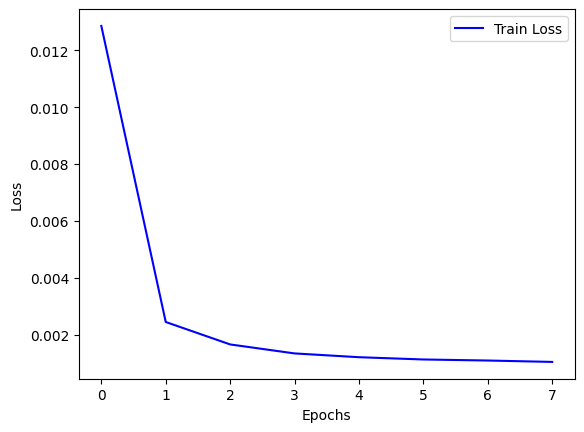

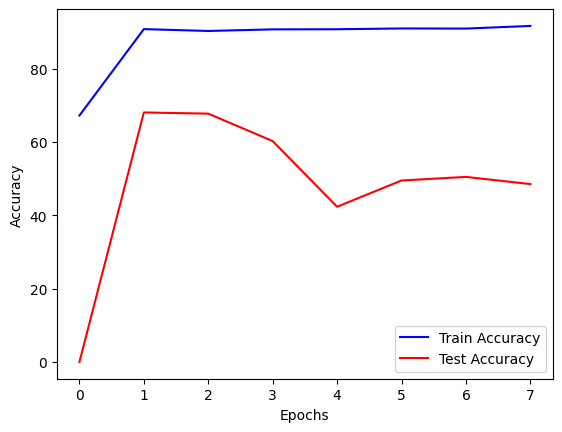

In [30]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)